# Crack Detection
- dataset 확인, train / valid / test 분할
- dataset 비율 맞추어 재설정
- custom CNN model 구현, 학습 및 결과 확인
- Pretrained resnet fine- tuning, 학습 및 결과 확인
- 첫 번째 layer filter 값 확인

by 20201635 컴퓨터공학과 전찬

In [1]:
# torch cuda error detection을 위해 추가,, 삭제 해도 괜찮습니다.
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DL project checking dataset

## drive mount and unzip

In [2]:
# based on https://khanhha.github.io/portfolio/crack-segmentation/#Dataset

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# dataset 압축 해제
!unzip -qq "/content/drive/MyDrive/dl_project/crack_segmentation_dataset.zip"

## checking dataset size

In [4]:
# file 개수 파악 함수 추가
import os
from pathlib import Path

def get_files_count(path):
  list_of_data = os.listdir(path)
  #print(list_of_data)
  return len(list_of_data), list_of_data

# 실제로 test data는 validation dataset으로 사용할 예정
print("all data size :", get_files_count('/content/crack_segmentation_dataset/images')[0])
print("train data size :", get_files_count('/content/crack_segmentation_dataset/train/images')[0])
print("test data size :", get_files_count('/content/crack_segmentation_dataset/test/images')[0])

# 총 dataset 11298 중 9603 / 1695 로 분할되어 있는 dataset 이며,
# 9603을 test, 1695 / 2 를 valid, 나머지를 test로 사용할 예정이다.

all data size : 11298
train data size : 9603
test data size : 1695


## checking unckrack data size

In [5]:
train_path = Path("/content/crack_segmentation_dataset/train/images")
test_path = Path("/content/crack_segmentation_dataset/test/images")

train_noncrack_data = train_path.glob('noncrack*.jpg')
test_noncrack_data = test_path.glob('noncrack*.jpg')

print("noncrack data size in train dataset :",len(list(train_noncrack_data)))
print("noncrack data size in test dataset :",len(list(test_noncrack_data)))


noncrack data size in train dataset : 1199
noncrack data size in test dataset : 212


## train / valid / test data로 분할
- 각 file을 images directory -> images/crack or images/noncrack으로 분리
- detection data loader을 간단하게 얻어낼 수 있습니다.
- crack / noncrack size가 1 : 1 비율이 되도록 조정했습니다.

In [6]:
# validation set 생성

import re

os.makedirs('/content/crack_segmentation_dataset/valid/images', exist_ok=True)
os.makedirs('/content/crack_segmentation_dataset/valid/masks', exist_ok=True)

# test dataset의 절반을 validation set으로 설정
for num, file_name in enumerate(get_files_count('/content/crack_segmentation_dataset/test/images')[1]):
  if not re.search('jpg', file_name):
    continue

  if num%2 == 0:
    os.rename('/content/crack_segmentation_dataset/test/images/'+file_name,
              '/content/crack_segmentation_dataset/valid/images/'+file_name)
    os.rename('/content/crack_segmentation_dataset/test/masks/'+file_name,
              '/content/crack_segmentation_dataset/valid/masks/'+file_name)



In [7]:
import re

train_crack_count = 0 # 각 1200개의 crack / noncrack으로 분할할 수 있도록
valid_crack_count = 0 # 각 105개의 crack / noncrack
test_crack_count = 0 # 각 105개의 crack / noncrack


os.makedirs('/content/crack_segmentation_dataset/train/images/crack', exist_ok=True)
os.makedirs('/content/crack_segmentation_dataset/train/images/noncrack', exist_ok=True)

os.makedirs('/content/crack_segmentation_dataset/valid/images/crack', exist_ok=True)
os.makedirs('/content/crack_segmentation_dataset/valid/images/noncrack', exist_ok=True)

os.makedirs('/content/crack_segmentation_dataset/test/images/crack', exist_ok=True)
os.makedirs('/content/crack_segmentation_dataset/test/images/noncrack', exist_ok=True)

# trainset 분할
for file_name in get_files_count('/content/crack_segmentation_dataset/train/images')[1]:
  if not re.search('jpg', file_name):
    continue

  if re.match("noncrack", file_name):
    os.rename('/content/crack_segmentation_dataset/train/images/'+file_name,
              '/content/crack_segmentation_dataset/train/images/noncrack/'+file_name)
  else:
    if train_crack_count > 1200:
      continue
    train_crack_count += 1
    os.rename('/content/crack_segmentation_dataset/train/images/'+file_name,
              '/content/crack_segmentation_dataset/train/images/crack/'+file_name)

# valid set 분할
for file_name in get_files_count('/content/crack_segmentation_dataset/valid/images')[1]:
  if not re.search('jpg', file_name):
    continue

  if re.match("noncrack", file_name):
    os.rename('/content/crack_segmentation_dataset/valid/images/'+file_name,
              '/content/crack_segmentation_dataset/valid/images/noncrack/'+file_name)
  else:
    if valid_crack_count > 105:
      continue
    valid_crack_count += 1
    os.rename('/content/crack_segmentation_dataset/valid/images/'+file_name,
              '/content/crack_segmentation_dataset/valid/images/crack/'+file_name)

# test set 분할
for file_name in get_files_count('/content/crack_segmentation_dataset/test/images')[1]:
  if not re.search('jpg', file_name):
    continue

  if re.match("noncrack", file_name):
    os.rename('/content/crack_segmentation_dataset/test/images/'+file_name,
              '/content/crack_segmentation_dataset/test/images/noncrack/'+file_name)
  else:
    if test_crack_count > 105:
      continue
    test_crack_count += 1
    os.rename('/content/crack_segmentation_dataset/test/images/'+file_name,
              '/content/crack_segmentation_dataset/test/images/crack/'+file_name)




In [ ]:
train_crack_path = Path("/content/crack_segmentation_dataset/train/images/crack")
train_noncrack_path = Path("/content/crack_segmentation_dataset/train/images/noncrack")

valid_crack_path = Path("/content/crack_segmentation_dataset/test/images/crack")
valid_noncrack_path = Path("/content/crack_segmentation_dataset/test/images/noncrack")

test_crack_path = Path("/content/crack_segmentation_dataset/test/images/crack")
test_noncrack_path = Path("/content/crack_segmentation_dataset/test/images/noncrack")


train_crack_data = train_crack_path.glob('*.jpg')
train_noncrack_data = train_noncrack_path.glob('*.jpg')

valid_crack_data = valid_crack_path.glob('*.jpg')
valid_noncrack_data = valid_noncrack_path.glob('*.jpg')

test_crack_data = test_crack_path.glob('*.jpg')
test_noncrack_data = test_noncrack_path.glob('*.jpg')

print("train crack data :", len(list(train_crack_data)), "noncrack data :", len(list(train_noncrack_data)))
print("valid crack data :", len(list(valid_crack_data)), "noncrack data :", len(list(valid_noncrack_data)))
print("test crack data :", len(list(test_crack_data)), "noncrack data :", len(list(test_noncrack_data)))

train crack data : 1201 noncrack data : 1199
valid crack data : 106 noncrack data : 109
test crack data : 106 noncrack data : 109


## dataset image file 확인
- image 형태, shape 등을 확인했습니다.

noncrack_noncrack_concrete_wall_102_1.jpg.jpg


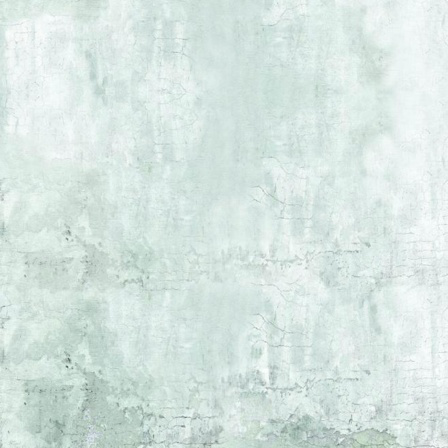

(448, 448)


In [15]:
from PIL import Image

file_number = 17 # file number에 따른

file_dir = "/content/crack_segmentation_dataset/train/images/noncrack" # file dir의 해당 number의 file을 시각화할 수 있도록

train_dataset_name = sorted(get_files_count(file_dir)[1])

print(train_dataset_name[file_number]) # 이미지 이름 확인
img1 = Image.open(file_dir + "/" + train_dataset_name[file_number]) # 이미지 파일명에 따라 이미지 불러오기
img1.show() # 이미지 확인

print(img1.size) # 이미지 size 확인

## Train / Valid / Test data loader 구현

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms

train_imagefolder = datasets.ImageFolder(root='/content/crack_segmentation_dataset/train/images/',
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                    ])
                                   )

valid_imagefolder = datasets.ImageFolder(root='/content/crack_segmentation_dataset/valid/images/',
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                    ])
                                   )

test_imagefolder = datasets.ImageFolder(root='/content/crack_segmentation_dataset/test/images/',
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                    ])
                                   )

# 모두 crack : 0, noncrack : 1 에 해당하는지 확인

print("train data label class :", train_imagefolder.class_to_idx)
print("valid data label class :", valid_imagefolder.class_to_idx)
print("test data label class :", test_imagefolder.class_to_idx)

train data label class : {'crack': 0, 'noncrack': 1}
valid data label class : {'crack': 0, 'noncrack': 1}
test data label class : {'crack': 0, 'noncrack': 1}


In [ ]:
import torch

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_imagefolder,         # image_folder를 지정
                                           batch_size=batch_size,# 배치사이즈 지정
                                           shuffle=True)       # shuffle 여부 지정

valid_loader = torch.utils.data.DataLoader(valid_imagefolder,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(test_imagefolder,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
# 각 image의 shape 확인
print("shape per data :", next(iter(train_loader))[0][0].shape)
print("shape data per batch:", next(iter(train_loader))[0].shape)
print("shape label per batch :", next(iter(train_loader))[1].shape)

shape per data : torch.Size([3, 448, 448])
shape data per batch: torch.Size([64, 3, 448, 448])
shape label per batch : torch.Size([64])


# CNN 기반 custom model 구현 및 학습 수행



## custom model 정의
- 7x7 / 3x3 / 3x3 filter을 갖는 CNN model 구현

In [ ]:
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class CrackClassifier(nn.Module):
  def __init__(self, input_dim = 3, hidden_dim = 16, output_dim = 2):
    super().__init__() # nn.Module에 대한 init 수행

    # 구조 자체는 VGG에 따라 3 x 3 filter을 사용하는 것이 합리적일 수 있지만,
    # 시각화를 위해 7 x 7 filter을 사용했다.
    self.cnn_layer1 = nn.Conv2d(input_dim, hidden_dim, kernel_size = 7, padding = 'same') # 3 -> hidden_dim
    self.cnn_layer2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size = 3, padding = 'same') # hidden_dim -> hidden_dim * 2
    self.cnn_layer3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size = 3, padding = 'same') # hidden_dim * 2 -> hidden_dim * 2
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2)
    self.global_pool = torch.nn.AdaptiveAvgPool2d(1)

    self.final_layer = nn.Linear(hidden_dim * 2, output_dim) # output_dim = 1로 binary classification 이다.
                                                             # output_dim = 2 로 변경했다.
                                                             # 이유는 pretrained ResNet load 과정에서 1로 설정하는 경우 에러 발생


  def forward(self, x):
    x = self.cnn_layer1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.cnn_layer2(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.cnn_layer3(x)
    x = self.relu(x)
    x = self.global_pool(x)
    x = torch.squeeze(x)

    x = self.final_layer(x)
    #x = torch.sigmoid(x) # CrossEntropy를 사용할 때, softmax가 CrossEntropy 부분에서 계산된다.

    return x

model = CrackClassifier()

In [ ]:
model(next(iter(train_loader))[0]).shape # model input으로 64x3x448x448일 때, output shape 확인

torch.Size([64, 2])

## accuracy function 정의, train / validation code 구현

In [ ]:
def accuracy_func(pred, label):
  correct_count = 0
  pred_argmax = torch.argmax(pred, dim = 1)
  for i in range(len(label)):
    if pred_argmax[i] == label[i]:
      correct_count += 1

  return correct_count / len(label)

def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[]
  valid_acc_records = []
  model.train() # Set model to train mode
  for epoch in tqdm(range(num_epochs), position = 0):
    for batch in tqdm(train_loader, position = 1, leave = False):
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      image, label = batch
      image = image.to(device)
      label = torch.Tensor([[1, 0] if target == 0 else [0, 1] for target in label]) # label 64 -> 64 x 2
      label = label.to(device)
      pred = model(image)
      #pred = torch.squeeze(pred) # 64x1 -> 64, loss function 적용을 위해
      loss = loss_func(pred, label.float())
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc)
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device, acc_func=accuracy_func):
  valid_acc = 0
  model.eval()
  model.to(device)
  with torch.no_grad():
    for batch in valid_loader:
      image, label = batch
      pred = model(image.to(device))
      auc = acc_func(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)

## custom CNN model 학습 수행
- optimizer = Adam
- loss_func = CrossEntropyLoss 사용

2-class classification 이기 때문에, BCE도 사용할 수 있습니다.

In [ ]:
DEV = 'cuda'

model.to(DEV)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.CrossEntropyLoss()

train_record = train_model(model, train_loader, valid_loader, optimizer, num_epochs=100, loss_func=loss_func, device=DEV)


100%|██████████| 100/100 [32:48<00:00, 19.68s/it]


## 학습 결과 시각화 및 testset accuracy 측정

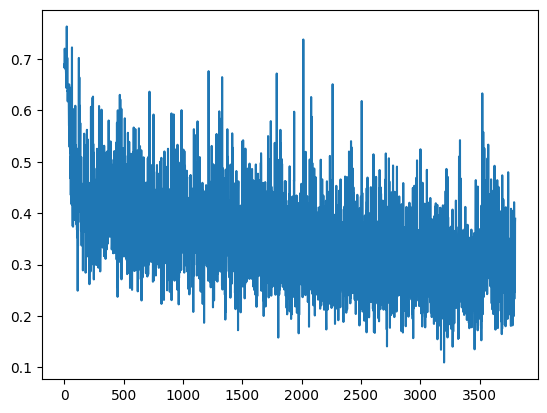

In [ ]:
plt.plot(train_record['loss'])

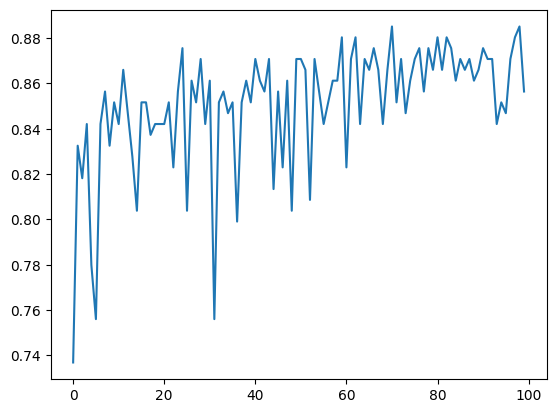

In [ ]:
plt.plot(train_record['valid_acc'])

In [ ]:
# test 결과 확인
test_acc = validate_model(model, test_loader, 'cuda')
print(test_acc)

0.8465116279069768


# Pretrained Resnet 기반 fine-tuning model 구현


In [ ]:
# load resnet18 with the pre-trained weights
# by https://deep-learning-study.tistory.com/476

from torchvision import models
import torch

resnet18_pretrained = models.resnet18(weights = 'DEFAULT')

#print(resnet18_pretrained)

## model last FC layer output 변경
- 기존에는 image 분류를 위해 1000개의 output이 존재했습니다. 이를 crack / noncrack인 2개로 변경했습니다.

In [ ]:
# 해당 layer 들의 requires_grad = true로 설정되어 있기 때문에, weight를 freeze해 주어야 한다.
for name, param in resnet18_pretrained.named_parameters():
  param.requires_grad = False

num_class = 2
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_class)
resnet18_pretrained = resnet18_pretrained.to('cuda')

In [ ]:
# RGB / 448 x 448 size의 image input인 경우, resnet의 output 결과값 확인
# trainable param : 512 * 2 + 2 = 1,026 으로 나머지 weight는 freeze, fc layer만 trainable함을 파악할 수 있다.

from torchsummary import summary
summary(resnet18_pretrained, input_size=(3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
       BasicBlock-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,864
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

## accuracy function 정의, train / validation code 구현
- custom CNN model과 동일한 형식으로 구현했습니다.

In [ ]:
def accuracy_func(pred, label):
  correct_count = 0
  pred_argmax = torch.argmax(pred, dim = 1)
  for i in range(len(label)):
    if pred_argmax[i] == label[i]:
      correct_count += 1

  return correct_count / len(label)

def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[]
  valid_acc_records = []
  model.train() # Set model to train mode
  for epoch in tqdm(range(num_epochs), position = 0):
    for batch in tqdm(train_loader, position = 1, leave = False):
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      image, label = batch
      image = image.to(device)
      label = torch.Tensor([[1, 0] if target == 0 else [0, 1] for target in label]) # label 64 -> 64 x 2
      label = label.to(device)
      pred = model(image)
      #pred = torch.squeeze(pred) # 64x1 -> 64, loss function 적용을 위해
      pred = torch.sigmoid(pred) # pretrained resnet에 sigmoid가 존재하지 않아 해당 layer 추가
      loss = loss_func(pred, label.float())
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc)
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device, acc_func=accuracy_func):
  valid_acc = 0
  model.eval()
  model.to(device)
  with torch.no_grad():
    for batch in valid_loader:
      image, label = batch
      pred = model(image.to(device))
      auc = acc_func(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)

## Pretrained Resnet fine-tuning model 학습 수행

In [ ]:
# 직접 구현한 model과 동일한 방법으로 학습 수행

DEV = 'cuda'

resnet18_pretrained.to(DEV)

optimizer = torch.optim.Adam(resnet18_pretrained.parameters(), lr=1e-3)
loss_func = torch.nn.CrossEntropyLoss()

resnet_train_record = train_model(resnet18_pretrained, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

100%|██████████| 30/30 [09:52<00:00, 19.75s/it]


## 학습 결과 시각화 및 testset accuracy 측정

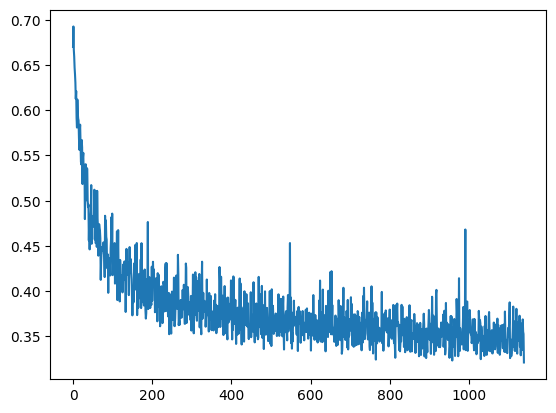

In [ ]:
plt.plot(resnet_train_record['loss'])

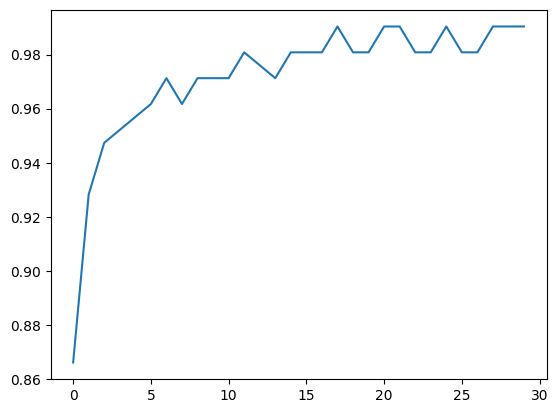

In [ ]:
plt.plot(resnet_train_record['valid_acc'])

In [ ]:
# test 결과 확인
test_acc = validate_model(resnet18_pretrained, test_loader, 'cuda')
print(test_acc)

0.9813953488372092


# CNN layer filter visualization
- 첫 번째 CNN layer filter은 RGB로 visualization이 가능합니다.

## custom CNN model fiter visualization

torch.Size([16, 3, 7, 7])


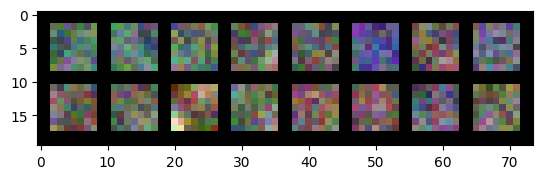

In [ ]:
# filter visualization

import torchvision

# visualize the filters of the first CNN layer in custom CNN
for w in model.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

plt.imshow(torchvision.utils.make_grid(w, normalize = True).permute(1,2,0))
plt.show()

## Pretrained Resnet fine-tuning model fiter visualization

torch.Size([64, 3, 7, 7])


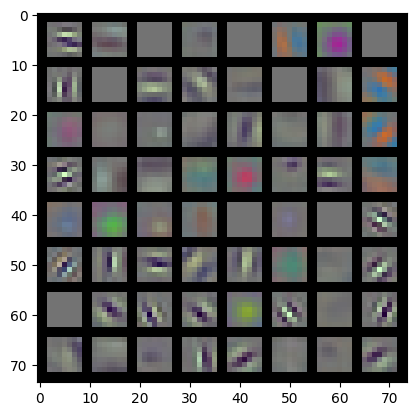

In [ ]:
# visualize the filters of the first CNN layer in pretrained resnet
for w in resnet18_pretrained.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

plt.imshow(torchvision.utils.make_grid(w, normalize = True).permute(1,2,0))
plt.show()